<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Введение" data-toc-modified-id="Введение-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Введение</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Чтение-и-обработка-данных" data-toc-modified-id="Чтение-и-обработка-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Чтение и обработка данных</a></span></li><li><span><a href="#Формирование-выборок" data-toc-modified-id="Формирование-выборок-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Формирование выборок</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span><ul class="toc-item"><li><span><a href="#Объявление-функций-для-обучения" data-toc-modified-id="Объявление-функций-для-обучения-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Объявление функций для обучения</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#LinearSVC" data-toc-modified-id="LinearSVC-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>LinearSVC</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>SGDClassifier</a></span></li><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li></ul></li><li><span><a href="#Результаты-обучения" data-toc-modified-id="Результаты-обучения-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Результаты обучения</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Определение токсичности текста

## Введение

**Описание задачи:**  
Интернет-магазин запускает новый сервис: пользователи могут предлагать свои правки описаний товаров и комментировать изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.   

**Цели исследования:**  
Необходимо построить модель машинного обучения, которая будет классифицировать комментарии на позитивные и негативные. Обучение происходит на наборе данных с разметкой о токсичности правок.
- Целевой признак - является ли комментарий токсичным `toxic`.
- Метрикой выступает `F1`, её значение не должно быть меньше 0.75.  

**Ход исследования:**
1. Подготовка данных.
2. Формирование признаков, обучение моделей.
3. Тестирование и выбор моделей.

## Предобработка данных

### Импорт библиотек

Импортирую библиотеки и объявляю константы.

In [92]:
import pandas as pd
import numpy as np
import re
import nltk
import spacy
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import notebook
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV,  train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

In [48]:
SEED = 340513

### Чтение и обработка данных

In [49]:
df = pd.read_csv('toxic_comments.csv')
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [50]:
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 159292 │ │ int32       │ 2     │                                                          │
│ │ Number of columns │ 3      │ │ string      │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓  │
│ ┃ column_name      ┃ NA   ┃ NA %    ┃ mean     ┃ sd       ┃ p0   ┃ p25      ┃ p75      ┃ p100     ┃ hist     ┃  │
│ ┡━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩  │
│ │ Unnamed: 0       │    0 │       0 │    80000 │    46000 │    0 │    40000 │   120000 │   160000 │  ██████  │  │
│ │ toxic            │    0 │       0 │      0.1 │      0.3 │    0 │        0 │        0 │        1 │  █    ▁  │  │
│ └──────────────────┴──────┴─────────┴──────────┴──────────┴──────┴──────────┴──────────┴──────────┴──────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ text                      │       0 │          0 │                           68 │                 11000000 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

В датасете нет пропущенных значений, уберу лишний признак.

In [51]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,""" More I can't make any real suggestions on im...",0
4,"You, sir, are my hero. Any chance you remember...",0


Наблюдается дисбаланс классов, нужно учесть это при обучении.

In [52]:
df['toxic'].value_counts().values

array([143106,  16186], dtype=int64)

Уберу все символы из текста кроме латиницы и пробелов.

In [53]:
df['text'] = pd.Series(
    map(
        lambda x: ' '.join(re.sub(r'[^a-zA-Z]', ' ', x.lower()).split()),
        df['text']
    )
)

Лемматизирую преобразованный текст, сохраню результат в отдельный признак.

In [54]:
m = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
df['text_lem'] = pd.Series(
    map(
        lambda x: ' '.join(token.lemma_ for token in m(x)),
        df['text']
    )
)
df.head()

C:\Users\khrom\anaconda3\envs\practicum\lib\site-packages\spacy\language.py:1895: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


,text,toxic,text_lem
0,explanation why the edits made under my userna...,0,explanation why the edit make under my usernam...
1,d aww he matches this background colour i m se...,0,d aww he match this background colour I m seem...
2,hey man i m really not trying to edit war it s...,0,hey man I m really not try to edit war it s ju...
3,more i can t make any real suggestions on impr...,0,more I can t make any real suggestion on impro...
4,you sir are my hero any chance you remember wh...,0,you sir be my hero any chance you remember wha...


### Формирование выборок

Выделяю тренеровочную и тестовую выборку в соотношении 3:1, при делении учтен дисбаланс классов. 

In [55]:
features_train, features_test, target_train, target_test = train_test_split(
    df['text_lem'], df['toxic'], test_size=0.25, random_state=SEED,
    stratify=df['toxic']
)

## Обучение модели

### Объявление функций для обучения

Функция `teach_model` создает пайплайн, который преобразует данные с помощью `TfidfVectorizer`, обучает модель и выводит результаты обучения. 

In [104]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def teach_model(classifier, grid, tf_idf=True, cv=10):
    step = []
    
    if tf_idf:
        step.append(('transformer', TfidfVectorizer(stop_words=stop_words)))
        
    step.append(('classifier', GridSearchCV(estimator=classifier, cv=cv,
                                             scoring='f1',
                                             param_grid=grid)))
    
    pipe = Pipeline(steps=step)
    
    pipe.fit(features_train, target_train)
    model = pipe.named_steps.classifier
    print('Best params:', model.best_params_)
    
    pipe.all_scores_ = test_model(pipe, features_train, target_train)
    
    return pipe

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khrom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Функция `test_model` выводит результаты метрик для указанных признаков, таргета и пайплайна.

In [105]:
def test_model(pipe, feat, targ, return_result=True):
    result = {}
    proba = True
    predictions = pipe.predict(feat)
    result['accuracy'] = accuracy_score(targ, predictions)
    
    try:
        proba_one = pipe.predict_proba(feat)[:, 1]
        result['roc_auc'] = roc_auc_score(targ, proba_one)
    except:
        result['roc_auc'] = -1
        proba = False
    
    result['recall'] = recall_score(targ, predictions)
    result['precision'] = precision_score(targ, predictions)
    result['f1'] = f1_score(targ, predictions)
    
    result = pd.DataFrame(result, index=['score'])
    
    display(result)
    print('Confusion_matrix:')
    display(
        pd.DataFrame(confusion_matrix(targ, predictions),
                     columns=['N_pred', 'P_pred'],
                     index=['N_answer', 'P_answer'])
    )
    
    if proba:
        fpr, tpr, thresholds = roc_curve(targ, proba_one)
        ax = sns.lineplot(x=fpr, y=tpr)
        sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', ax=ax)
        ax.set_title('ROC curve', fontsize=15)
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
    
    if return_result:
        return result

### Обучение моделей

Обученные модели будут храниться в словаре, расшифровка ключей:
- `log` - логистическая регрессия
- `svc` - LinearSVC
- `sgd` - SGDClassifier  
- `dummy` - проверка моделей на адекватность

In [106]:
models = {}

#### Логистическая регрессия

Значение основной метрики - 0.889, неплохой результат.

Best params: {'C': 5, 'class_weight': 'balanced', 'max_iter': 1500, 'n_jobs': -1, 'penalty': 'l2'}


,accuracy,roc_auc,recall,precision,f1
score,0.974947,0.996565,0.992257,0.806022,0.889496


Confusion_matrix:


,N_pred,P_pred
N_answer,104430,2899
P_answer,94,12046


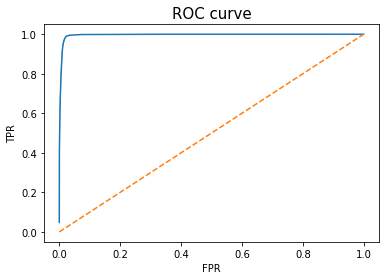

In [107]:
models['log'] = teach_model(
    LogisticRegression(),
    {
        'max_iter': [1500],
        'C': [5],
        'penalty': ['l2'],
        'class_weight': ['balanced'],
        'n_jobs': [-1]
    }
)

#### LinearSVC

Значение метрики чуть хуже чем у логистической регрессии - 0.885.

In [108]:
models['svc'] = teach_model(
    LinearSVC(),
    {
        'loss': ['squared_hinge'],
        'max_iter': [3000],
        'C': [0.4],
        'penalty': ['l2'],
        'random_state': [SEED],
        'class_weight': ['balanced'],
        
    }
)

Best params: {'C': 0.4, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'max_iter': 3000, 'penalty': 'l2', 'random_state': 340513}


,accuracy,roc_auc,recall,precision,f1
score,0.973776,-1,0.991763,0.798779,0.884871


Confusion_matrix:


,N_pred,P_pred
N_answer,104296,3033
P_answer,100,12040


#### SGDClassifier

Значение метрики 0.92 - лучший результат. Стоит отметить высокое значение `precision`, однако `recall` хуже чем у других моделей.

Best params: {'alpha': 1e-05, 'class_weight': None, 'loss': 'modified_huber', 'max_iter': 1500, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 340513, 'tol': 0.005}


,accuracy,roc_auc,recall,precision,f1
score,0.985101,0.996426,0.88402,0.966499,0.923421


Confusion_matrix:


,N_pred,P_pred
N_answer,106957,372
P_answer,1408,10732


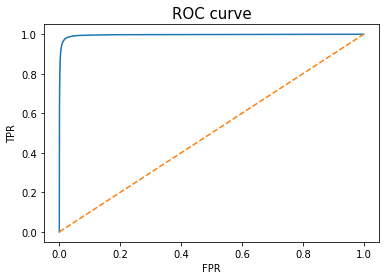

In [109]:
models['sgd'] = teach_model(
    SGDClassifier(),
    {
        'loss': ['modified_huber'],
        'alpha': [1e-5],
        'max_iter': [1500],
        'penalty': ['l2'],
        'tol': [5e-3],
        'random_state': [SEED],
        'class_weight': [None],
        'n_jobs': [-1]
    }
)

#### Проверка на адекватность

Все модели прошли проверку на адекватость.

Best params: {'random_state': 340513, 'strategy': 'stratified'}


,accuracy,roc_auc,recall,precision,f1
score,0.818966,0.50197,0.104119,0.105193,0.104653


Confusion_matrix:


,N_pred,P_pred
N_answer,96577,10752
P_answer,10876,1264


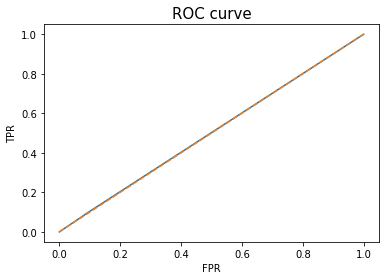

In [110]:
models['dummy'] = teach_model(
    DummyClassifier(),
    {
        'strategy': ['stratified'],
        'random_state': [SEED],
    }
)

### Результаты обучения

`SGDClassifier` показала лучшие результаты на обучении, выбираю эту модель для тестирования.

In [111]:
pd.concat([models[i].all_scores_ for i in models], keys=[i for i in models]).sort_values(by='f1', ascending=False)\
    .reset_index(drop=True, level=1)

,accuracy,roc_auc,recall,precision,f1
sgd,0.985101,0.996426,0.884020,0.966499,0.923421
log,0.974947,0.996565,0.992257,0.806022,0.889496
svc,0.973776,-1.000000,0.991763,0.798779,0.884871
dummy,0.818966,0.501970,0.104119,0.105193,0.104653


## Тестирование модели

Значение метрики 0.79, результат удовлетворяет требованиям. 

,accuracy,roc_auc,recall,precision,f1
score,0.960952,0.957177,0.723678,0.870134,0.790177


Confusion_matrix:


,N_pred,P_pred
N_answer,35340,437
P_answer,1118,2928


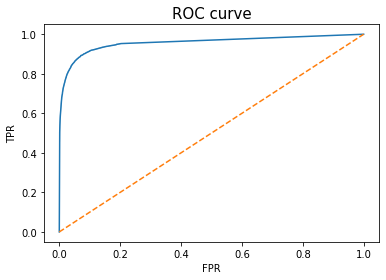

In [112]:
test_model(models['sgd'], features_test, target_test, return_result=False)

## Общий вывод

Целью этого исследования выступало построение модели машинного обучения, которая будет классифицировать комментарии на позитивные и негативные. Обучение происходило на наборе данных с разметкой о токсичности правок. Условиями являлись:  
- Целевой признак - является ли комментарий токсичным `toxic`.
- Метрикой выступает `F1`, её значение не должно быть меньше 0.75.  

Была проведена работа над исходным датасетом:
- Из исходного датасета был удален ненужный признак, выявлен дисбаланс классов.
- Текст очищен от ненужных символов, проведена лемматизация.
- Выборка была разделена на тренеровочную и тестовую в соотношении 3:1.
- Сформирована матрица признаков для обучения.
- Объявлены функции для обучения и тестирования моделей.  

Расшифровка обученных моделей:
- `log` - логистическая регрессия
- `svc` - LinearSVC
- `sgd` - SGDClassifier  
- `dummy` - проверка моделей на адекватность


Все модели прошли проверку на адекватность на стадии обучения. Прошла тестирование следующая модель:
- `sgd`:
    - `F1 = 0.79`
    - `precision = 0.87`
    - `recall = 0.72`
    - `accuracy = 0.96`
    - `ROC-AUC = 0.96`  